In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns

from PIL import Image
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img, load_img
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2 as cv

import random
from sklearn.metrics import classification_report, confusion_matrix
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from keras.models import Sequential
from keras.layers import Dense,Conv2D,Dropout,Flatten,MaxPooling2D, BatchNormalization,Input,concatenate, AveragePooling2D
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras.utils import plot_model
import tensorflow as tf

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames[:1]:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Build Dataset

In [5]:
# create dictionary of relationship between label and sign
categories = {0:"0",1:"1",2:"2",3:"3",4:"4",5:"5",6:"6",7:"7",8:"8",9:"9",
              10:"a",11:"b",12:"c",13:"d",14:"e",15:"f",16:"g",17:"h",18:"i",
              19:"j",20:"k",21:"l",22:"m",23:"n",24:"o",25:"p",26:"q",27:"r",
              28:"s",29:"t",30:"u",31:"v",32:"w",33:"x",34:"y",35:"z"}

In [6]:
# create dataframe from images in directory
data_path = '/kaggle/input/asl-dataset/asl_dataset'
root_dir = os.listdir(data_path)
file_list = []
image_list = []
label_list = []

for directory in root_dir:
    directory_path = f"{data_path}/{directory}"
    if not os.path.isdir(directory_path) or directory=='asl_dataset':
        continue
    for files in os.listdir(f"{data_path}/{directory}"):
        file_path = f"{data_path}/{directory}/{files}"
        file_list.append(file_path)
        label_list.append(directory)
        img = imread(file_path)
        image_list.append(np.array(img))
df = pd.DataFrame({'file':file_list,'image':image_list,'label':label_list})
df

FileNotFoundError: [WinError 3] The system cannot find the path specified: '/kaggle/input/asl-dataset/asl_dataset'

# Visualize Dataset

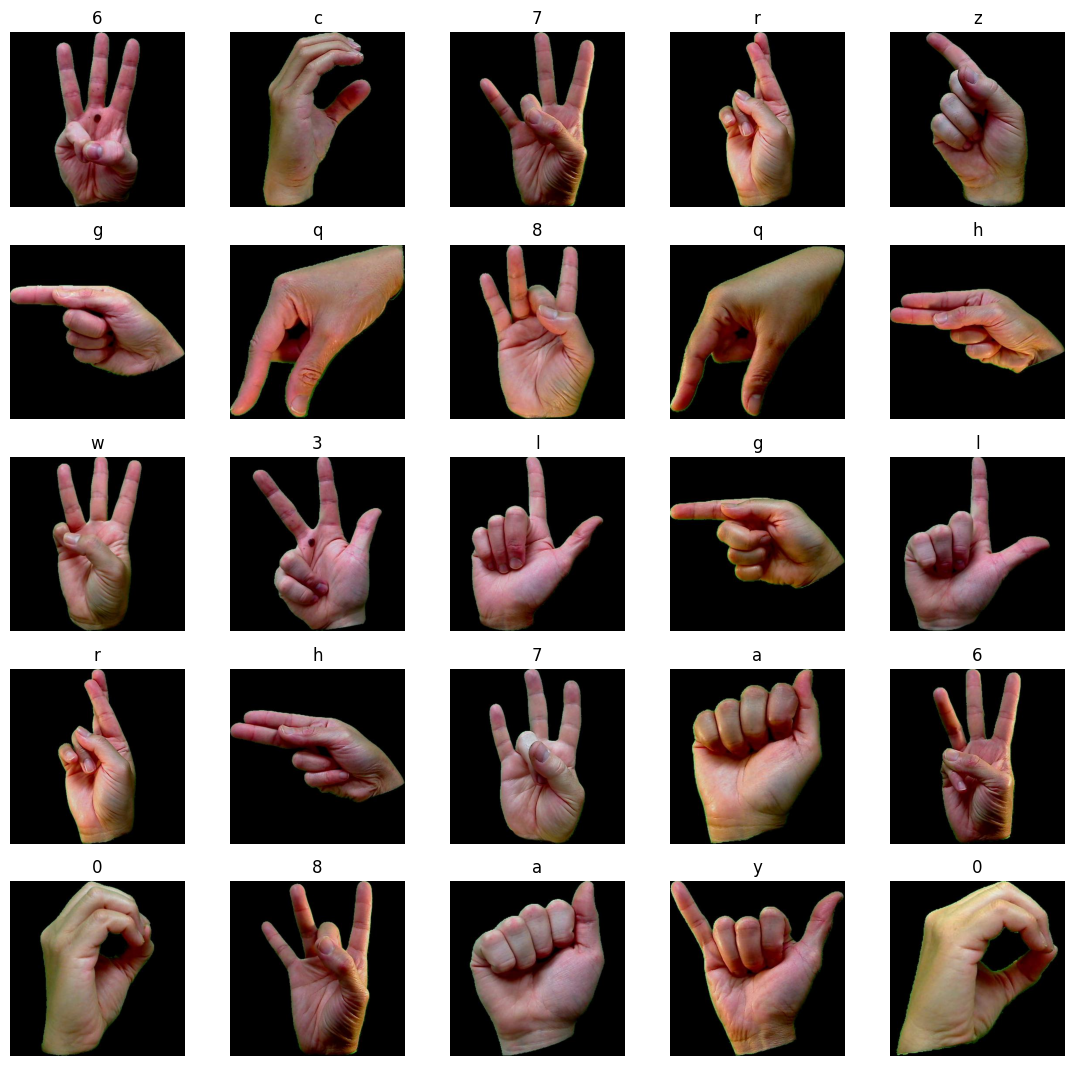

In [4]:
# visualize data
plt.figure(figsize=(11,11))
for i in range(1,26):
    plt.subplot(5,5,i)
    plt.tight_layout()
    plt.axis('off')
    randval = random.choice(list(categories.values()))
    randimg = imread(data_path + '/' + randval + '/' + random.choice(sorted(os.listdir(data_path + '/' + randval + '/'))))
    plt.imshow(randimg)
    plt.title(randval)

Text(0.5, 1.0, 'Count of Images by Sign')

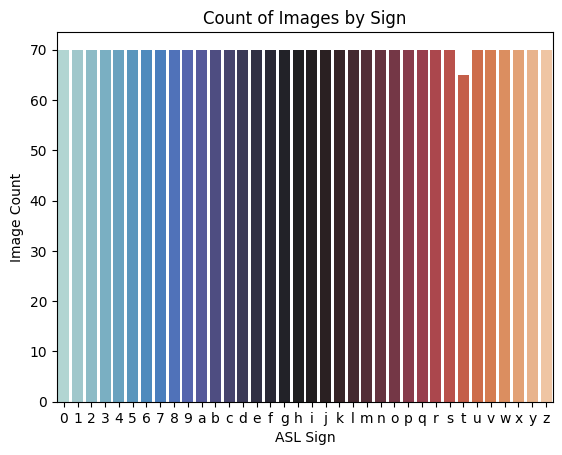

In [5]:
# visualize distribution of images by sign in dataset
sign_freq = df['label'].value_counts().reset_index().sort_values('label')
sns.barplot(sign_freq, x='label', y='count', palette='icefire')
plt.xlabel('ASL Sign')
plt.ylabel('Image Count')
plt.title('Count of Images by Sign')

# Prepare Data for Model

In [6]:
# split dataframe into train, test, and validation
x_train, x_test0, y_train, y_test0 = train_test_split(df['file'], df['label'], test_size=0.25, random_state=42)
x_test, x_val, y_test, y_val = train_test_split(x_test0, y_test0, test_size=0.5, random_state=42)
train = pd.concat([x_train,y_train], axis=1).reset_index(drop=True)
test = pd.concat([x_test,y_test], axis=1).reset_index(drop=True)
val = pd.concat([x_val, y_val], axis=1).reset_index(drop=True)
print(np.shape(train))
print(np.shape(test))
print(np.shape(val))
test

(1886, 2)
(314, 2)
(315, 2)


,file,label
0,/kaggle/input/asl-dataset/asl_dataset/6/hand2_...,6
1,/kaggle/input/asl-dataset/asl_dataset/v/hand1_...,v
2,/kaggle/input/asl-dataset/asl_dataset/m/hand2_...,m
3,/kaggle/input/asl-dataset/asl_dataset/e/hand1_...,e
4,/kaggle/input/asl-dataset/asl_dataset/x/hand2_...,x
...,...,...
309,/kaggle/input/asl-dataset/asl_dataset/f/hand1_...,f
310,/kaggle/input/asl-dataset/asl_dataset/4/hand1_...,4
311,/kaggle/input/asl-dataset/asl_dataset/b/hand2_...,b
312,/kaggle/input/asl-dataset/asl_dataset/6/hand1_...,6


In [7]:
# normalize image data and transform into train, test, and validation datasets
image_size = 128
batchsize = 32
class_size = 36

datagen = ImageDataGenerator(rescale=1.0/255)

train_data = datagen.flow_from_dataframe(dataframe=train, x_col='file', y_col='label', target_size=(image_size,image_size), batch_size = batchsize, class_mode='categorical')

test_data = datagen.flow_from_dataframe(dataframe=test, x_col='file', y_col='label', target_size=(image_size,image_size), shuffle=False, batch_size=batchsize, class_mode='categorical')

val_data = datagen.flow_from_dataframe(dataframe=val, x_col='file', y_col='label', target_size=(image_size,image_size), shuffle=False, batch_size = batchsize, class_mode='categorical')

Found 1886 validated image filenames belonging to 36 classes.
Found 314 validated image filenames belonging to 36 classes.
Found 315 validated image filenames belonging to 36 classes.


# Implement CNN Model

In [8]:
# Initialize model
model = Sequential()

model.add(Conv2D(32, (5,5), activation = 'relu', input_shape = (image_size,image_size,3)))
# model.add(Conv2D(32, 3, activation = 'relu', padding='same'))
model.add(MaxPooling2D(padding='same')) # v3


model.add(Conv2D(64, (5,5), activation = 'relu'))
model.add(MaxPooling2D(padding='same')) # v3

# model.add(Conv2D(64, (5,5), activation = 'relu', padding='same')) #v4
# model.add(MaxPooling2D(padding='same')) # v4  0.9458598494529724

model.add(Flatten())

model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5)) # v3

model.add(Dense(36, activation = 'softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2  (None, 62, 62, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 58, 58, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 29, 29, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 53824)             0         
                                                                 
 dense (Dense)               (None, 128)               6

In [9]:
# Initialize callbacks
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, restore_best_weights=True, verbose=0)
reducelr = ReduceLROnPlateau(monitor='val_accuracy', patience=2, factor=0.5, verbose=1)

In [10]:
# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
# Train CNN model on training data
classifier = model.fit(train_data, validation_data=val_data, epochs=10, callbacks=[earlystop,reducelr], verbose=1) # Test Accuracy = 0.9681528806686401

Epoch 1/10
59/59 [==============================] - 42s 684ms/step - loss: 1.9963 - accuracy: 0.4555 - val_loss: 0.6268 - val_accuracy: 0.8413 - lr: 0.0010
Epoch 2/10
59/59 [==============================] - 39s 657ms/step - loss: 0.6182 - accuracy: 0.8022 - val_loss: 0.3520 - val_accuracy: 0.9048 - lr: 0.0010
Epoch 3/10
59/59 [==============================] - 39s 662ms/step - loss: 0.3583 - accuracy: 0.8950 - val_loss: 0.2815 - val_accuracy: 0.9206 - lr: 0.0010
Epoch 4/10
59/59 [==============================] - 39s 660ms/step - loss: 0.2467 - accuracy: 0.9215 - val_loss: 0.2596 - val_accuracy: 0.9270 - lr: 0.0010
Epoch 5/10
59/59 [==============================] - 40s 671ms/step - loss: 0.1653 - accuracy: 0.9449 - val_loss: 0.2458 - val_accuracy: 0.9460 - lr: 0.0010
Epoch 6/10
59/59 [==============================] - 42s 711ms/step - loss: 0.1488 - accuracy: 0.9507 - val_loss: 0.1846 - val_accuracy: 0.9619 - lr: 0.0010
Epoch 7/10
59/59 [==============================] - 39s 657ms/st

In [12]:
train_loss, train_accuracy = model.evaluate(train_data)
print('Train Accuracy =', train_accuracy)
print('Train Loss =', train_loss)

59/59 [==============================] - 10s 174ms/step - loss: 0.0030 - accuracy: 1.0000
Train Accuracy = 1.0
Train Loss = 0.0030278575140982866


In [13]:
val_loss, val_accuracy = model.evaluate(val_data)
print('Validation Accuracy =', val_accuracy)
print('Validation Loss =', val_loss)

10/10 [==============================] - 2s 217ms/step - loss: 0.2367 - accuracy: 0.9524
Validation Accuracy = 0.9523809552192688
Validation Loss = 0.2366795688867569


In [14]:
test_loss, test_accuracy = model.evaluate(test_data)
print('Test Accuracy =', test_accuracy)
print('Test Loss =', test_loss)

10/10 [==============================] - 2s 176ms/step - loss: 0.1065 - accuracy: 0.9650
Test Accuracy = 0.9649681448936462
Test Loss = 0.10651340335607529


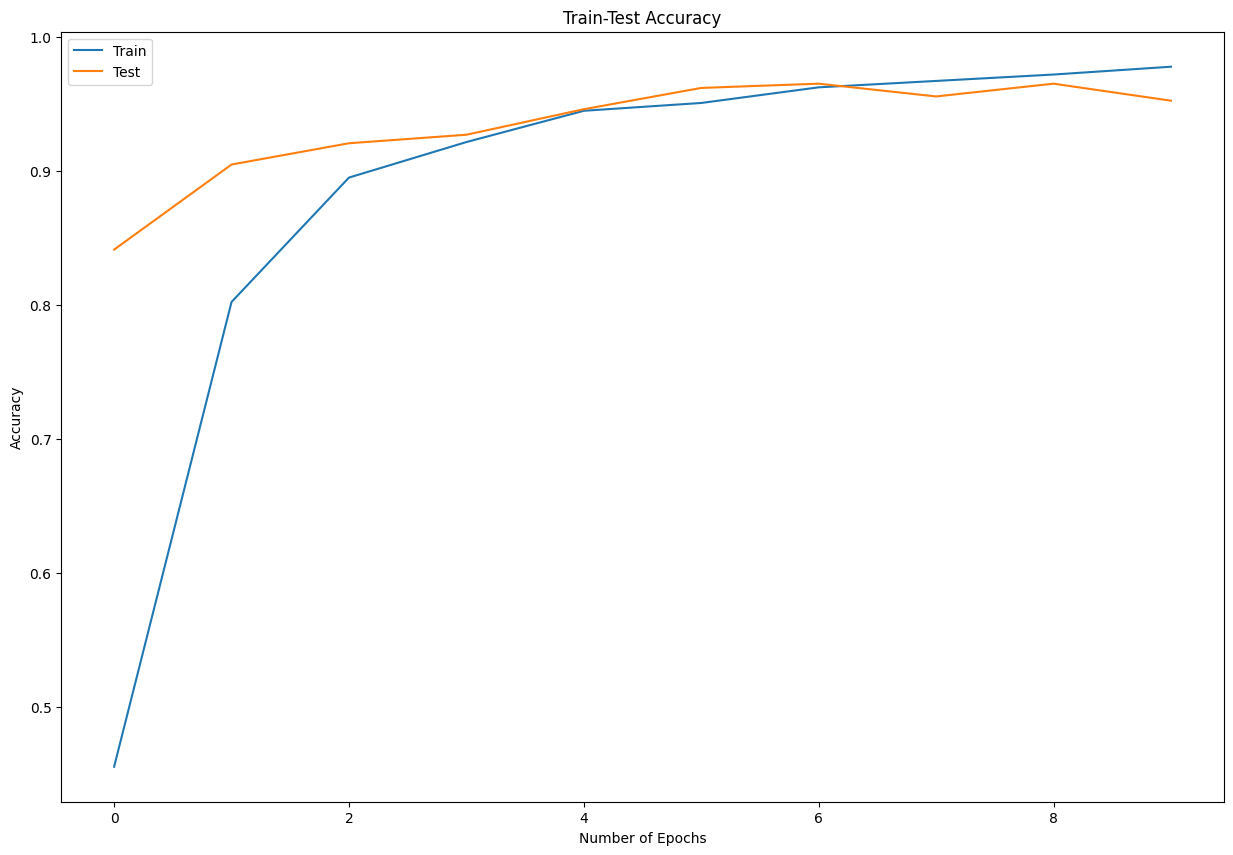

In [15]:
# Visualize accuracy on training and testing groups across epochs
plt.figure(figsize = (15, 10))   
epochs= []
for i in range(10):
    epochs.append(i)
    
plt.plot(epochs,classifier.history['accuracy'], label="Train")
plt.plot(epochs,classifier.history['val_accuracy'], label="Test")
plt.title("Train-Test Accuracy")
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

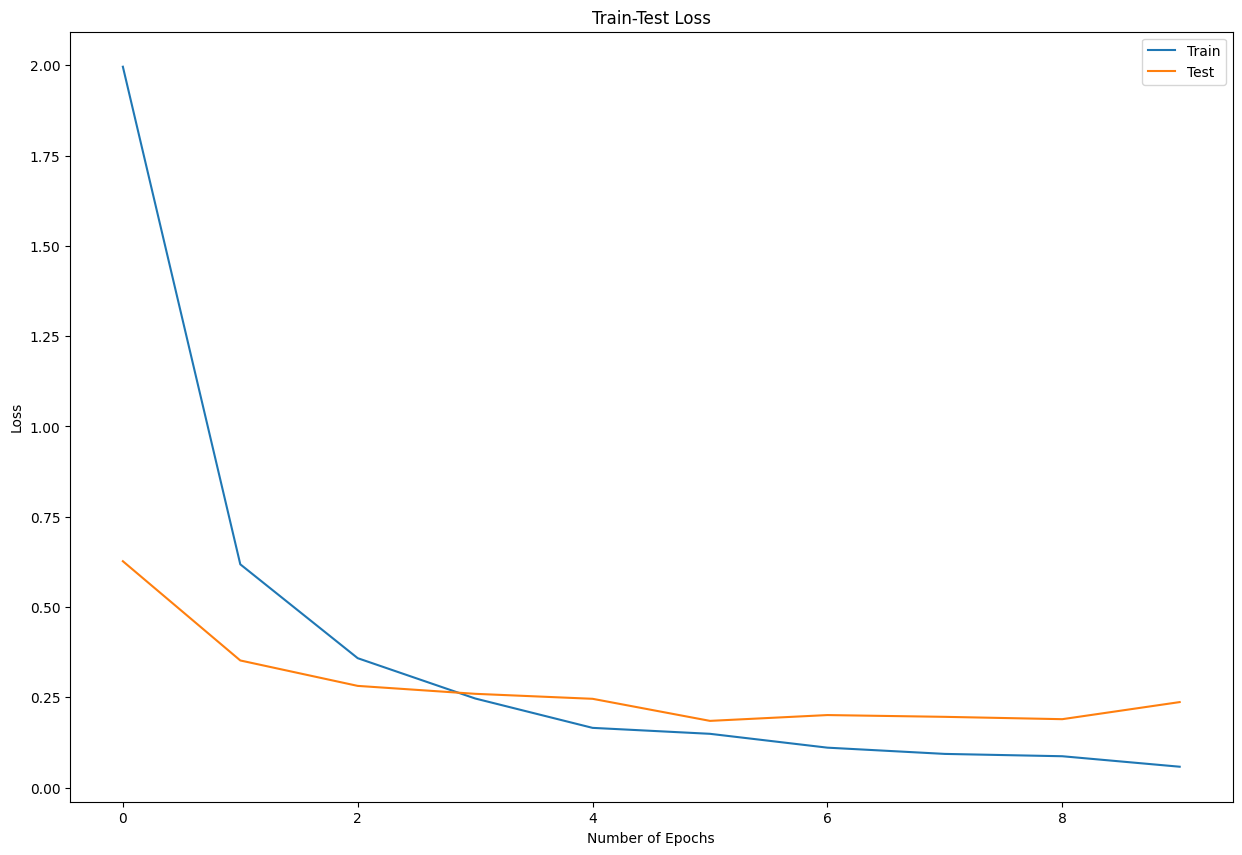

In [16]:
# Visualize loss on training and testing groups across epochs
plt.figure(figsize = (15, 10))   
plt.plot(epochs,classifier.history['loss'], label="Train")
plt.plot(epochs,classifier.history['val_loss'], label="Test")
plt.title("Train-Test Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [17]:
# Predict on testing dataset and assess accuracy
probs = model.predict(test_data, verbose = 0)
y_pred = np.argmax(probs, axis = 1)
y_actual = test_data.labels

test_loss, test_accuracy = model.evaluate(test_data,verbose = 0)

print('Testing Accuracy:', test_accuracy)
print('Testing Loss:', test_loss, '\n')

correct = np.nonzero(y_pred==y_actual)[0]
incorrect = np.nonzero(y_pred!=y_actual)[0]

print("Correct predicted classes:",correct.shape[0])
print("Incorrect predicted classes:",incorrect.shape[0], '\n')

print(classification_report(y_pred, y_actual))

Testing Accuracy: 0.9649681448936462
Testing Loss: 0.10651340335607529 

Correct predicted classes: 303
Incorrect predicted classes: 11 

              precision    recall  f1-score   support

           0       0.91      0.91      0.91        11
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         8
           3       1.00      1.00      1.00        11
           4       0.92      0.92      0.92        12
           5       0.91      1.00      0.95        10
           6       0.92      1.00      0.96        12
           7       0.88      1.00      0.93         7
           8       1.00      0.80      0.89        10
           9       1.00      1.00      1.00        11
          10       1.00      1.00      1.00        11
          11       1.00      1.00      1.00         9
          12       1.00      1.00      1.00         8
          13       1.00      1.00      1.00         9
          14       1.00      1.00      1.00        

Text(0.5, 1.0, 'Confusion Matrix')

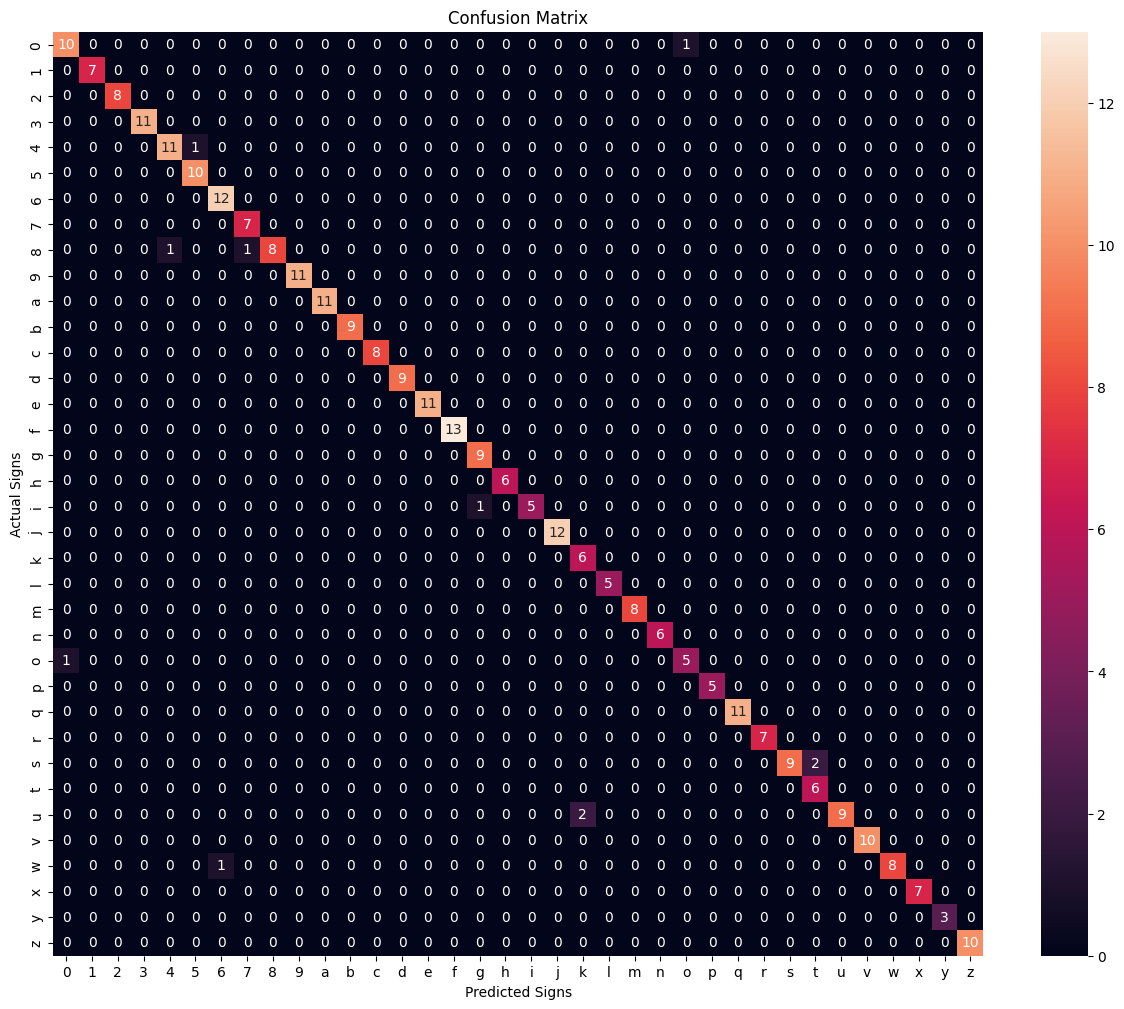

In [18]:
# Visualize confusion matrix of classifications
plt.figure(figsize = (15, 12))   
matrix = confusion_matrix(y_pred, y_actual)
matrixdf = pd.DataFrame(matrix, index=categories.values(), columns=categories.values())
sns.heatmap(matrixdf,annot=True,fmt='g')
plt.xlabel("Predicted Signs")
plt.ylabel("Actual Signs")
plt.title("Confusion Matrix")

In [19]:
# Create reverse dictionary of sign and label
labeldict = {}
for key, value in test_data.class_indices.items():
    labeldict[value] = key

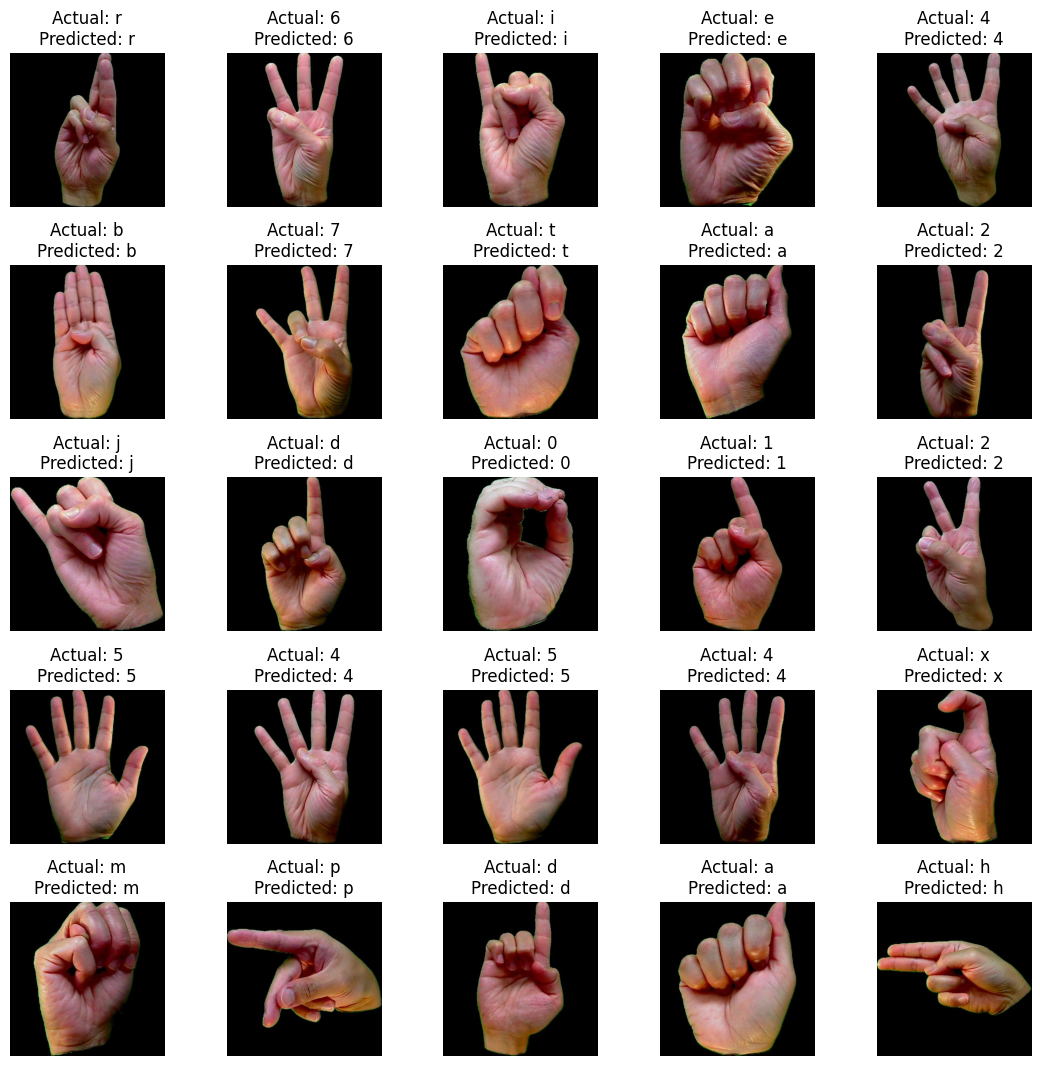

In [20]:
# visualize data predictions
plt.figure(figsize=(11,11))
for i in range(1,26):
    plt.subplot(5,5,i)
    plt.tight_layout()
    plt.axis('off')
    randind = random.randint(0, len(test)-1)
    plt.imshow(imread(test.iloc[randind]['file']))
    plt.title(f"Actual: {labeldict[y_actual[randind]]}\nPredicted: {labeldict[y_pred[randind]]}")

In [21]:
# Save trained model
model.save("model.h5")
trained_model = tf.keras.models.load_model("model.h5")

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [22]:
import cv2
import numpy as np
import tensorflow as tf
from keras.preprocessing.image import img_to_array

# Load the trained model
model = tf.keras.models.load_model


In [24]:
("model.h5")

# Define the dictionary of categories
categories = {
    0: "0", 1: "1", 2: "2", 3: "3", 4: "4", 5: "5", 6: "6", 7: "7", 8: "8", 9: "9",
    10: "a", 11: "b", 12: "c", 13: "d", 14: "e", 15: "f", 16: "g", 17: "h", 18: "i",
    19: "j", 20: "k", 21: "l", 22: "m", 23: "n", 24: "o", 25: "p", 26: "q", 27: "r",
    28: "s", 29: "t", 30: "u", 31: "v", 32: "w", 33: "x", 34: "y", 35: "z"
}

# Initialize webcam
cap = cv2.VideoCapture(0)

# Define the image size and preprocess function
image_size = 128

def preprocess_frame(frame):
    frame = cv2.resize(frame, (image_size, image_size))
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = img_to_array(frame)
    frame = np.expand_dims(frame, axis=0)
    frame = frame.astype('float32') / 255.0
    return frame

while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    # Preprocess the frame
    processed_frame = preprocess_frame(frame)
    
    # Predict the gesture
    predictions = model.predict(processed_frame)
    predicted_class = np.argmax(predictions)
    predicted_label = categories[predicted_class]
    
    # Display the result
    cv2.putText(frame, f'Predicted: {predicted_label}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
    cv2.imshow('Sign Language Gesture Recognition', frame)
    
    # Break the loop if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the webcam and close windows
cap.release()
# cv2.destroyAllWindows()


[ WARN:0@1213.592] global cap_v4l.cpp:997 open VIDEOIO(V4L2:/dev/video0): can't open camera by index
[ERROR:0@1213.592] global obsensor_uvc_stream_channel.cpp:159 getStreamChannelGroup Camera index out of range
